In [1]:
from datetime import timedelta
from datetime import datetime
import numpy as np
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.plotter import Plotterly

plotter = Plotterly()

truth = GroundTruthPath()
start_time = datetime.now()
for n in range(1, 202, 2):
    x = n -100
    y = 1e-4 * (n-100)**3
    varxy = np.array([[0.1, 0.], [0., 0.1]])
    xy = np.random.multivariate_normal(np.array([x, y]), varxy)
    truth.append(GroundTruthState(np.array([[xy[0]], [xy[1]]]),
                                  timestamp=start_time + timedelta(seconds=n)))

# Plot the result
plotter.plot_ground_truths({truth}, [0, 1])
plotter.fig

In [2]:
from scipy.stats import multivariate_normal
from stonesoup.types.detection import Detection
from stonesoup.models.measurement.linear import LinearGaussian

measurements = []
for state in truth:
    x, y = multivariate_normal.rvs(
        state.state_vector.ravel(), cov=np.diag([5., 5.]))
    measurements.append(Detection(
        [x, y], timestamp=state.timestamp))

# Plot the result
plotter.plot_measurements(measurements, [0, 1], LinearGaussian(2, (0, 1), np.diag([0, 0])))
plotter.fig

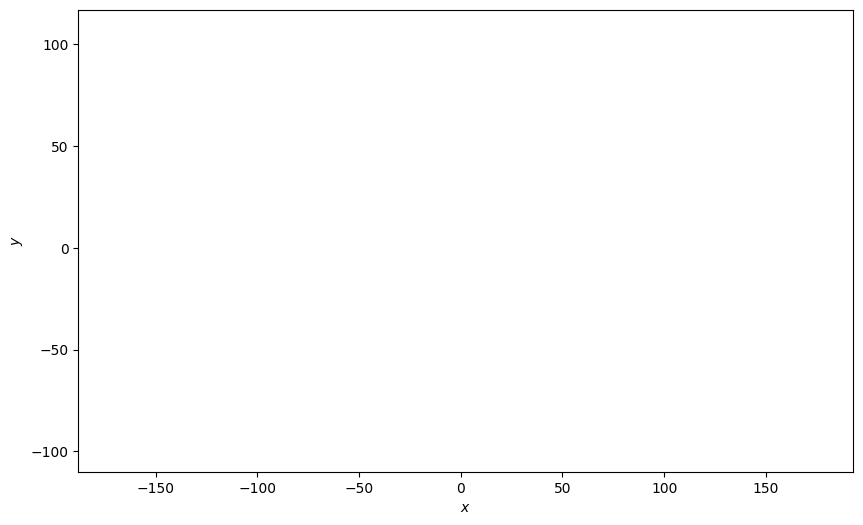

In [3]:
from stonesoup.models.transition.linear import \
    CombinedLinearGaussianTransitionModel, ConstantVelocity
from stonesoup.predictor.asd import ASDKalmanPredictor

transition_model = CombinedLinearGaussianTransitionModel(
    (ConstantVelocity(0.2), ConstantVelocity(0.2)))
predictor = ASDKalmanPredictor(transition_model)

from stonesoup.updater.asd import ASDKalmanUpdater

measurement_model = LinearGaussian(
    4,  # Number of state dimensions (position and velocity in 2D)
    (0, 2),  # Mapping measurement vector index to state index
    np.array([[5., 0.],  # Covariance matrix for Gaussian PDF
              [0., 5.]])
)
updater = ASDKalmanUpdater(measurement_model)

from stonesoup.types.state import ASDGaussianState

prior = ASDGaussianState(multi_state_vector=[[-100.], [0.], [-100.], [0.]],
                         timestamps=start_time,
                         multi_covar=np.diag([1., 1., 1., 1.]),
                         max_nstep=30)

import matplotlib
from matplotlib import animation
matplotlib.rcParams['animation.html'] = 'jshtml'

from stonesoup.plotter import Plotter
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

ani_plotter = Plotter()
frames = []
artists = []

track = Track()  # For ASD track
track2 = Track()  # For Gaussian state equivalent without ASD
processed_measurements = set()
for i in range(0, len(measurements)):
    if i > 10:
        if i % 10 != 0:  # or i%10==3:
            m = measurements[i]
            prediction = predictor.predict(prior, timestamp=m.timestamp)
            track2.append(prediction.state)  # This track will ignore OoS measurements
        else:
            # prediction and update of the newest measurement
            m = measurements[i]
            processed_measurements.add(m)
            prediction = predictor.predict(prior, timestamp=m.timestamp)
            hypothesis = SingleHypothesis(prediction, m)
            # Used to group a prediction and measurement together
            post = updater.update(hypothesis)
            track.append(post)
            track2.append(post.state)
            prior = track[-1]

            artists.extend(ani_plotter.plot_tracks(Track(track[-1].states), [0, 2], color='r'))
            artists.extend(
                ani_plotter.plot_measurements(processed_measurements, [0, 2], measurement_model))
            frames.append(artists); artists =[]
            for j in range(9, 0, -1):
                # prediction and update for all OOS measurement. Beginning with the latest one.
                m = measurements[i - j]
                processed_measurements.add(m)
                prediction = predictor.predict(prior, timestamp=m.timestamp)
                hypothesis = SingleHypothesis(prediction, m)
                # Used to group a prediction and measurement together
                post = updater.update(hypothesis)
                track.append(post)
                prior = track[-1]

                artists.extend(ani_plotter.plot_tracks(Track(track[-1].states), [0, 2], color='r'))
                artists.extend(ani_plotter.plot_measurements(
                    processed_measurements, [0, 2], measurement_model))
                frames.append(artists); artists = []
    else:
        # the first 10 steps are for beginning of the ASD so that it is numerically stable
        m = measurements[i]
        processed_measurements.add(m)
        prediction = predictor.predict(prior, timestamp=m.timestamp)
        hypothesis = SingleHypothesis(prediction, m)
        # Used to group a prediction and measurement together
        post = updater.update(hypothesis)
        track.append(post)
        track2.append(post.state)
        prior = track[-1]

        artists.extend(ani_plotter.plot_tracks(Track(track[-1].states), [0, 2], color='r'))
        artists.extend(
            ani_plotter.plot_measurements(processed_measurements, [0, 2], measurement_model))
        frames.append(artists); artists = []

animation.ArtistAnimation(ani_plotter.fig, frames)

In [4]:
from operator import attrgetter

asd_states = []
for state in reversed(list(track.last_timestamp_generator())):
    if state.timestamp not in (asd_state.timestamp for asd_state in asd_states):
        asd_states.extend(state.states)
asd_states = sorted(asd_states, key=attrgetter('timestamp'))

plotter.plot_tracks({track2}, [0, 2], uncertainty=True, line=dict(color='green'),
                    track_label="Equivalent track without ASD")
plotter.plot_tracks({Track(asd_states)}, [0, 2], line=dict(color='red'),
                    track_label="ASD Track")
plotter.fig